In [1]:
source("/frazer01/projects/CEGS/analysis/hla_type_1kgp/script/functions_hla_type.R")


In [28]:
dir.create("pipeline/impute"   , showWarnings = FALSE)
dir.create("pipeline/impute/cv", showWarnings = FALSE)

invisible(lapply(paste("pipeline/impute/cv", paste0("cv", 1:10), sep = "/"), function(x){dir.create(x, showWarnings = FALSE)}))

# Divide IDs into 10-step cross-validation

In [22]:
id2cv    = id2hla[ids,]
id2cv$cv = 0

id2cv = as.data.frame(rbindlist(lapply(sort(unique(id2cv$population)), function(pop)
{
    set.seed(1)
    
    x    = id2cv[ id2cv$population == pop, ]
    x$cv = sample(round((1:nrow(x)) / (nrow(x) / 10), digits = 0))
    
    x[x$cv == 0, "cv"] = 10
    
    return(x)
})), stringsAsFactors = FALSE)

In [30]:
invisible(lapply(1:10, function(ii)
{
    outfolder = paste("pipeline/impute/cv", paste0("cv", ii), sep = "/")
    writeLines(id2cv[ id2cv$cv == ii, "id"], paste(outfolder, "test.txt"    , sep = "/"), sep = "\n")
    writeLines(id2cv[ id2cv$cv != ii, "id"], paste(outfolder, "training.txt", sep = "/"), sep = "\n")
    
}))

# Use CARET to impute
- impute by gene: extract SNPs around gene and impute

In [89]:
suppressPackageStartupMessages(library(caret))

In [ ]:
get_vars = function(coord, type, ids_file, ids, vcf)
{
    add_cmd = ""
    gt      = "GN"
    
    if(type == "phased")
    {
        add_cmd = paste("|", "sed -E 's/\\|/\\t/g'")
        gt      = "GT"
    }
    
    command = paste("bcftools", "query", 
                    "-r", coord,
                    "-S", ids_file,
                    "-f", paste0('"%ID[\\t%', gt, ']\\n"'),
                    vcf,
                    add_cmd,
                    ""
                   )
    
    indata = fread(cmd = command, sep = "\t", header = FALSE, data.table = FALSE)
    indata = indata[ duplicated(indata[,1]) == FALSE, ]
    indata = add_rownames(indata)
    
    if(type == "phased")
    {
        colnames(indata) = paste(rep(ids, each = 2), rep(1:2, times = length(ids)), sep = ":")
    }else
    {
        indata           = cbind(indata, indata)
        colnames(indata) = paste(rep(ids, times = 2), rep(1:2, each = length(ids)), sep = ":")
        indata           = indata[, paste(rep(ids, each = 2), rep(1:2, times = length(ids)), sep = ":")]
    }
    
    return(indata)
}

extract_vars_by_gene = function(gene, ids_file, vcf_snps, vcf_hla_types, geneinfo)
{
    coord      = paste0(6, ":", geneinfo[gene, "start"] - 25000, "-", geneinfo[gene, "end"] + 25000)
    ids        = readLines(ids_file)
    responses  = get_vars(coord, "unphased", ids_file, ids, vcf_hla_types)
    covariates = get_vars(coord, "phased"  , ids_file, ids, vcf_snps     )
    
    return(list(covariates = covariates, responses = responses))
}

predict_by_type = function(type, training, testing, responses)
{
    training$outcome = as.numeric(responses[ type, rownames(training)])
    
    myfit      = suppressWarnings(lm(outcome ~ ., data = training))
    prediction = suppressWarnings(predict(object = myfit, newdata = testing))
    out        = data.frame(id        = rownames(testing), 
                            type      = type,
                            observed  = as.numeric(responses[ type, rownames(testing)]),
                            predicted = prediction
                           )
    
    return(out)
}

predict_cv = function(gene, cv, topred, id2cv, geneinfo)
{
    responses  = as.data.frame(as.matrix(topred[["responses" ]]) / 2)
    covariates = t(topred[["covariates"]])
    types      =   rownames(responses)
    descrCor   = suppressWarnings(cor(covariates))
    
    if(length(covariates[ covariates > 1]) > 0){covariates[ covariates > 1] = 1}

    if(length(descrCor[ is.na(descrCor) == TRUE]) > 0){descrCor[ is.na(descrCor) == TRUE] = 0}
    
    to_remove1     = colnames(covariates[, findCorrelation(descrCor, cutoff = 0.8)])
    to_remove2     = colnames(covariates[, colSums(covariates) == 0])
    covariates     = covariates[, !colnames(covariates) %in% c(to_remove1, to_remove2)]
    ids_train      = id2cv[ id2cv$cv != cv, "id"]
    ids_test       = id2cv[ id2cv$cv == cv, "id"]
    ids_train      = paste(rep(ids_train, times = 2), rep(1:2, each = length(ids_train)), sep = ":")
    ids_test       = paste(rep(ids_test , times = 2), rep(1:2, each = length(ids_test )), sep = ":")
    training       = as.data.frame(covariates[ ids_train, ])
    testing        = as.data.frame(covariates[ ids_test , ])
    out            = as.data.frame(rbindlist(lapply(types, function(type){predict_by_type(type, training, testing, responses)})), stringsAsFactors = FALSE)
    out$gene       = gene
    out$cv         = cv
    
    return(out)
}

run_predictions_by_gene = function(gene, ids_file, vcf_snps, vcf_hla_types, id2cv, geneinfo)
{
    message(gene, appendLF = FALSE)
    topred     = extract_vars_by_gene(gene, ids_file, vcf_snps, vcf_hla_types, geneinfo)
    prediction = as.data.frame(rbindlist(lapply(1:10, function(cv){predict_cv(gene, cv, topred, id2cv, geneinfo)})), stringsAsFactors = FALSE)
    
    fwrite(prediction, paste("pipeline/impute/cv", paste("prediction", gene, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
    
    #return(prediction)
}

#gene = "HFE"

#prediction = run_predictions_by_gene(gene, ids_file, vcf_snps, vcf_hla_types, id2cv, geneinfo)

invisible(lapply(geneinfo$gene, function(gene){run_predictions_by_gene(gene, ids_file, vcf_snps, vcf_hla_types, id2cv, geneinfo)}))

#prediction_list        = lapply(geneinfo$gene, function(gene){run_predictions_by_gene(gene, ids_file, vcf_snps, vcf_hla_types, id2cv, geneinfo)})
#names(prediction_list) = geneinfo$gene



HFE
F
V
P
G
H


In [233]:
plot_pred = function(type, gt, prediction)
{
    hist(prediction[ prediction$type == type & prediction$observed == gt, "predicted"], breaks = (-20:60) / 20, main = paste(type, gt))
}

psize(15,15)
layout(matrix(1:9, nrow = 3, byrow = FALSE))

types = sort(unique(prediction$type))
invisible(lapply(types, function(type)
{
    invisible(lapply(0:2, function(gt)
    {
        plot_pred(type, gt, prediction)
    }))
}))



ERROR: Error in hist.default(prediction[prediction$type == type & prediction$observed == : some 'x' not counted; maybe 'breaks' do not span range of 'x'


In [229]:
a

id,type,observed,predicted,gene,cv
<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>
HG01890:1,HFE.001:01:02,0.5,0.55973041,HFE,1
HG01990:1,HFE.001:01:02,0.0,-0.46034086,HFE,1
HG02051:1,HFE.001:01:02,0.5,-0.46034086,HFE,1
HG02419:1,HFE.001:01:02,0.5,0.05589671,HFE,1
HG02429:1,HFE.001:01:02,0.0,0.15411281,HFE,1
HG02484:1,HFE.001:01:02,0.5,-0.79094681,HFE,1
HG02439:1,HFE.001:01:02,0.5,-0.79094681,HFE,1
HG02501:1,HFE.001:01:02,0.0,-0.76444976,HFE,1
HG02549:1,HFE.001:01:02,0.5,-1.15034938,HFE,1


In [ ]:

psize = function (w, h) 
{
    options(repr.plot.height = h, repr.plot.width = w)
}

plot_pred = function(type, gt, prediction)
{
    hist(prediction[ prediction$type == type & prediction$observed == gt, "predicted"], breaks = (-20:60) / 20, main = paste(type, gt))
}



psize(20,12)
layout(matrix(1:12, nrow = 3, byrow = FALSE))

invisible(lapply(geneinfo$gene, function(gene)
{
    prediction = prediction_list[[gene]]
    types      = sort(unique(prediction$type))
    invisible(lapply(types, function(type)
    {
        invisible(lapply(0:2, function(gt)
        {
            plot_pred(type, gt, prediction)
        }))
    }))
}))



In [202]:
range(prediction$predicted)

[1] -0.6871008  2.5561322

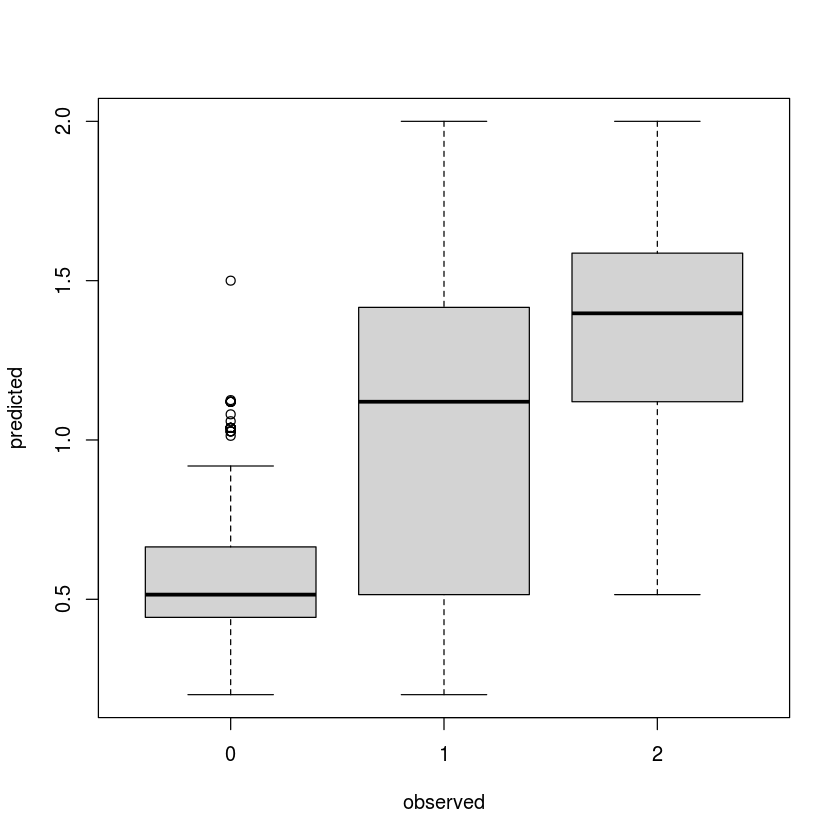

In [193]:
boxplot(predicted ~ observed, data = predicted)

In [76]:
a = c(1,3,2)
rep(a, each = 2)

[1] 1 1 3 3 2 2

# Impute by step

In [67]:
divide_vcf = function(x, vcf, outfolder)
{
    outfile = paste(outfolder, paste(x, "vcf.gz", sep = "."), sep = "/")
    id_file = paste(outfolder, paste(x, "txt"   , sep = "."), sep = "/")
    command = paste("bcftools", "view", 
                    "-S", id_file,
                    "-O", "z",
                    "-o", outfile,
                    vcf
                   )
    
    #system(command)
    
    command = paste("bcftools", "index", "-t", outfile)

    #system(command)
    
    return(outfile)
}

impute_by_step = function(ii)
{
    map_file   = "/frazer01/software/beagle-5.4/plink.GRCh37.map/plink.chr6.GRCh37.map"
    outfolder  = paste(getwd(), "pipeline/impute/cv", paste0("cv", ii), sep = "/")
    vcf_train  = divide_vcf("training", vcf_combined, outfolder)
    vcf_test   = divide_vcf("test"    , vcf_snps    , outfolder)
    impute_out = paste(outfolder, "impute.out", sep = "/")
    command    = paste("/frazer01/software/jdk-16.0.1/bin/java", 
                       "–Xmx64G", 
                       "–jar", "/frazer01/software/beagle-5.4/beagle.08Feb22.fa4.jar",
                       paste("gt"      , vcf_test  , sep = "="),
                       paste("ref"     , vcf_train , sep = "="),
                       paste("out"     , impute_out, sep = "="),
                       paste("map"     , map_file  , sep = "="),
                       paste("gp"      , "true"    , sep = "="),
                       paste("seed"    ,  1        , sep = "="),
                       paste("nthreads", 12        , sep = "="),
                       ""
                      )
    
    message(command)
}

ii = 1
a = impute_by_step(ii)


/frazer01/software/jdk-16.0.1/bin/java –Xmx64G –jar /frazer01/software/beagle-5.4/beagle.08Feb22.fa4.jar gt=/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/impute/cv/cv1/test.vcf.gz ref=/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/impute/cv/cv1/training.vcf.gz out=/frazer01/projects/CEGS/analysis/hla_type_1kgp/pipeline/impute/cv/cv1/impute.out map=/frazer01/software/beagle-5.4/plink.GRCh37.map/plink.chr6.GRCh37.map gp=true seed=1 nthreads=12 

